In [1]:
using Pkg 

Pkg.activate("..")

using MiCRM_stability
using LinearAlgebra
using StatsBase
using Distributions
using JLD2
using Random
using Graphs

using CairoMakie

  Activating project at `~/Projects/MiCRM_stability`


In [12]:
#get parameter names
fe = fieldnames(MiCRM_stability.exponential_params)
fs = fieldnames(MiCRM_stability.structural_params)
fs = filter(x -> x ∉ [:χ,:ϕ,:γ, :η], fs)
    
names =  vcat(fe...,fs..., "Cu", "Cd", "s")

# #latex names
fe_L = [L"g^{(x)}",L"g^{(s)}",L"m^{(x)}",L"f^{(y)}",L"\lambda^{(y)}",L"i^{ (y)}",L"o^{(y)}"]
fs_L = [L"\alpha",L"\beta",L"\Lambda^*",L"\rho",L"\tilde{\rho}",L"\sigma",L"\tilde{\sigma}",L"C_U", L"C_D"]

# #concatanate
names = string.(names)
names_L = vcat(fe_L,fs_L)

# #filter parameters
p_ind = collect(1:16)
rm_ind = findall(names .∈ Ref(["γ","η","χ","ϕ","σ̃","ρ̃","λy","fy"]))
p_ind = filter(x -> x .∉ Ref(rm_ind), p_ind)

# #filter name vectors
names = names[p_ind]
names_L = names_L[p_ind]

# #load
res = load("../Results/data/new_sims/dynamic_stabiltiy.jld2")

Dict{String, Any} with 3 entries:
  "v" => 0
  "l" => Complex[-0.0596122+0.0im, -0.171546+0.0im, 3.38332+0.0im, -0.440745+0.…
  "p" => Any[[0.251008, 0.993084, 1.05896, 1.0, 0.0, 0.119203, 0.738082, 1.0, 1…

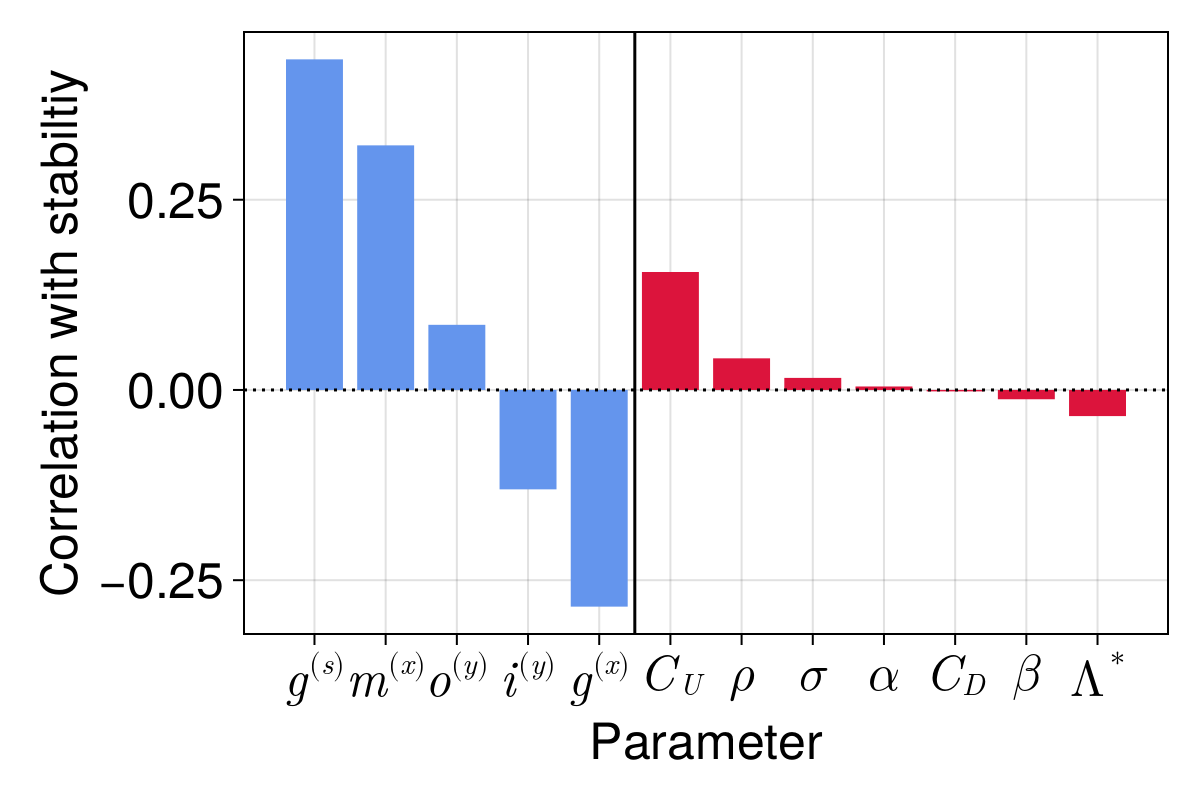

In [13]:
#get stability and correlate
p_mat = hcat(res["p"]...)[p_ind,:]
stab = [x.re < 0 for x = res["l"]]
stability_cor = [cor(abs.(p), stab) for p = eachrow(p_mat)]

#get color
c = vcat(fill(:cornflowerblue, length(fe_L)), fill(:crimson, length(fs_L)))
c = c[p_ind]

#sort
# ind = sortperm((stability_cor),rev=true)
ind = vcat(sortperm((stability_cor[1:5]),rev=true),5 .+ sortperm((stability_cor[6:end]),rev=true))

f = Figure(size = (600,400))
ax = Axis(f[1,1], xticks = (1:length(names), names_L[ind]),
    xlabel = "Parameter", ylabel = "Correlation with stabiltiy",
    xticklabelsize = 25, yticklabelsize = 25,
    xlabelsize = 25, ylabelsize = 25)

barplot!(ax, stability_cor[ind], color = c[ind])
hlines!(ax, [0], linestyle = :dot, color = "black")
vlines!(ax, [5.5], color = :black)

f

In [286]:
save("../Results/Figures/stability_correlations.svg", f)
save("../Results/Figures/stability_correlations.pdf", f)

CairoMakie.Screen{PDF}


In [14]:
#get parameter names
names =  vcat(fieldnames(MiCRM_stability.exponential_params)...,
    fieldnames(MiCRM_stability.structural_params)...)

#latex names
fe_L = [L"g_x",L"g_s",L"m_x",L"f_y",L"\lambda_y",L"i_y",L"o_y"]
fs_L = [L"\alpha",L"\beta",L"\Lambda",L"\rho",L"\tilde{\rho}",L"\sigma",L"\tilde{\sigma}",L"\gamma",L"\eta",L"\chi",L"\phi"]

#concatanate
names = string.(names)
names_L = vcat(fe_L,fs_L)

#filter parameters
p_ind = collect(1:18)
keep_ind = findall(names .∈ Ref(["fy","λy"]))
p_ind = filter(x -> x .∈ Ref(keep_ind), p_ind)

#filter name vectors
names = names[p_ind]
names_L = names_L[p_ind]

#load
res = load("../Results/data/new_sims/switching_stabiltiy.jld2")

Dict{String, Any} with 2 entries:
  "l" => Complex[0.995391+0.0im, 65.7287+0.0im, 206.141+0.0im, -0.23643+0.0im, …
  "p" => Any[[0.919622, 1.04848, 1.21912, 0.720981, -0.457664, 0.0, 1.0, 25.24,…

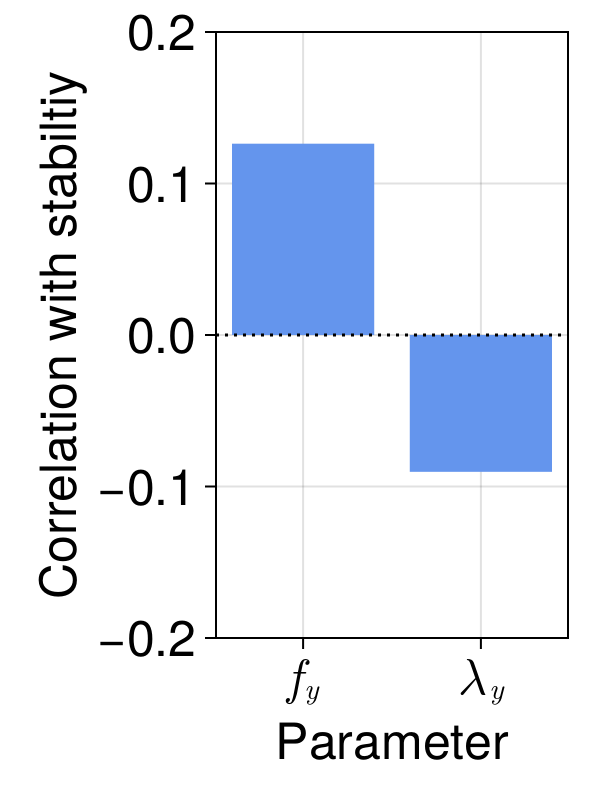

In [15]:
#get stability and correlate
p_mat = hcat(res["p"]...)[p_ind,:]
stab = [x.re < 0 for x = res["l"]]
stability_cor = [cor(abs.(p),stab) for p = eachrow(p_mat)]

#get color
c = vcat(fill(:cornflowerblue, length(fe_L)), fill(:crimson, length(fs_L)))
c = c[p_ind]

#sort
ind = sortperm(stability_cor, rev = true)
# ind = vcat(sortperm((stability_cor[1:7]),rev=true),7 .+ sortperm((stability_cor[8:end]),rev=true))


f = Figure(size = (300,400))
ax = Axis(f[1,1], xticks = (1:length(names), names_L[ind]),
    xlabel = "Parameter", ylabel = "Correlation with stabiltiy",
    xticklabelsize = 25, yticklabelsize = 25,
    xlabelsize = 25, ylabelsize = 25)
barplot!(ax, stability_cor[ind], color = c[ind])
hlines!(ax, [0], linestyle = :dot, color = "black")
ylims!(-0.2,0.2)

f

In [16]:
save("../Results/Figures/switching_correlations.svg", f)

CairoMakie.Screen{SVG}


In [510]:
res = load("../Results/data/new_sims/size_stability3.jld2")

stab = [x.re < eps() for x = res["l"]];

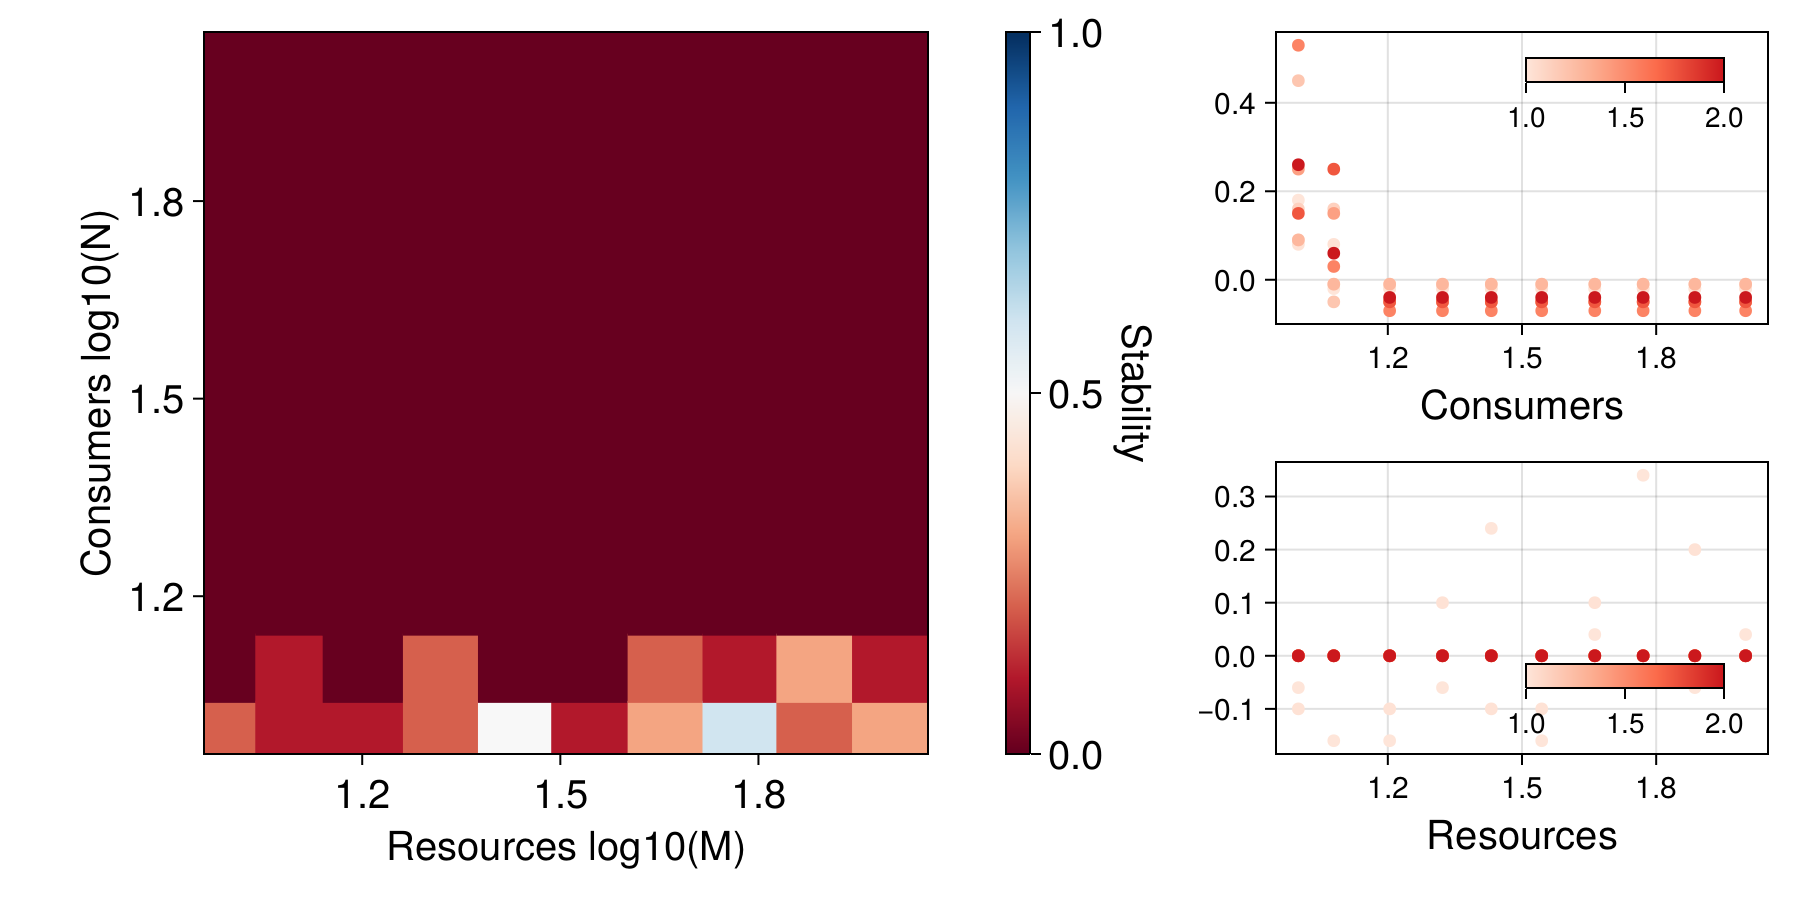

In [511]:
#params
#params
N=10
M=10
Np = 250


n_vec = Int.(floor.(10 .^ range(1, log10(100), length = N)))
m_vec = Int.(floor.(10 .^range(1, log10(100), length = M)))
N_mat = [n_vec[i] for i = 1:N, j = 1:M]
M_mat = [m_vec[j] for i = 1:N, j = 1:M]


f = Figure(size = (900,450))
ax = Axis(f[1:2,1], ylabel = "Consumers log10(N)", xlabel = "Resources log10(M)", aspect = 1, xticklabelsize = 20, yticklabelsize = 20, xlabelsize = 20, ylabelsize = 20)

stab = mean(stab,dims=3)[:,:,1]
cm =  (:RdBu)
heatmap!(ax, log10.(n_vec), log10.(m_vec), stab', colormap = (cm), colorrange = (0,1))

Colorbar(f[1:2,2], colormap = (cm), label = "Stability", flip_vertical_label = true, labelsize = 20, ticklabelsize = 20, colorrange = (0,1))

cm = :Reds_4
ax = Axis(f[1,3], xlabel = "Consumers",  xticklabelsize = 15, yticklabelsize = 15, xlabelsize = 20, ylabelsize = 20)
for a = 1:M
    scatter!(ax,log10.(N_mat[:,a] ), stab[:,a] .- mean(stab[:,a]) , color = m_vec[a], colormap = cm, colorrange = extrema(n_vec))
end
cb = Colorbar(f[1,3],colorrange=extrema(log10.(m_vec)), colormap = cm,
    tellwidth=false, tellheight = false, vertical = false,
    width = Relative(0.4), halign=0.85, valign=0.9,flipaxis = false)
# text!(ax, 68,0.185,text = "M", align = (:left,:center))


ax = Axis(f[2,3], xlabel = "Resources", xticklabelsize = 15, yticklabelsize = 15, xlabelsize = 20, ylabelsize = 20)
for i = 1:N
    scatter!(ax,log10.(M_mat[i,:] ), stab[i,:] .- mean(stab[i,:]), color = n_vec[i], colormap = cm, colorrange = extrema(n_vec))
end
cb = Colorbar(f[2,3],colorrange=extrema(log10.(n_vec)), colormap = cm,
    tellwidth=false, tellheight = false, vertical = false,
    width = Relative(0.4), halign=0.85, valign=0.25,flipaxis = false)
# text!(ax, 68,-0.39,text = "N", align = (:left,:center))

# scatter!(ax, log10.(N_mat[:]), stab[:] - 0.3*log10.(M_mat[:]) .+ 0.5)

colsize!(f.layout, 1, Relative(0.61))
colgap!(f.layout,2,20)

f

In [236]:
save("../Results/Figures/size_correlations.pdf", f)
save("../Results/Figures/size_correlations.svg", f)

CairoMakie.Screen{SVG}


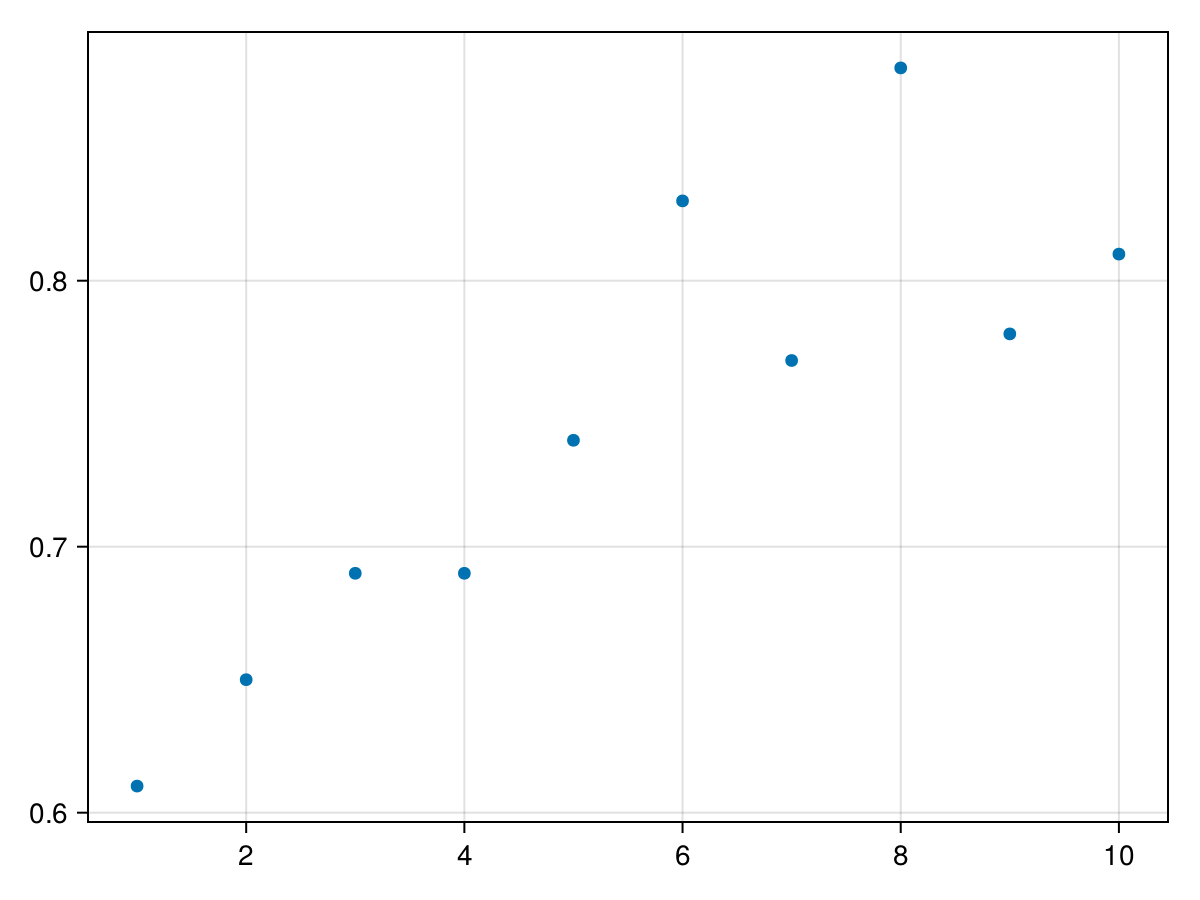

In [397]:
res = load("../Results/data/new_sims/nested_stabiltiy.jld2")

stab = [x.re < 0 for x = res["l"]]

mean(stab,dims=2)[:] |> plot

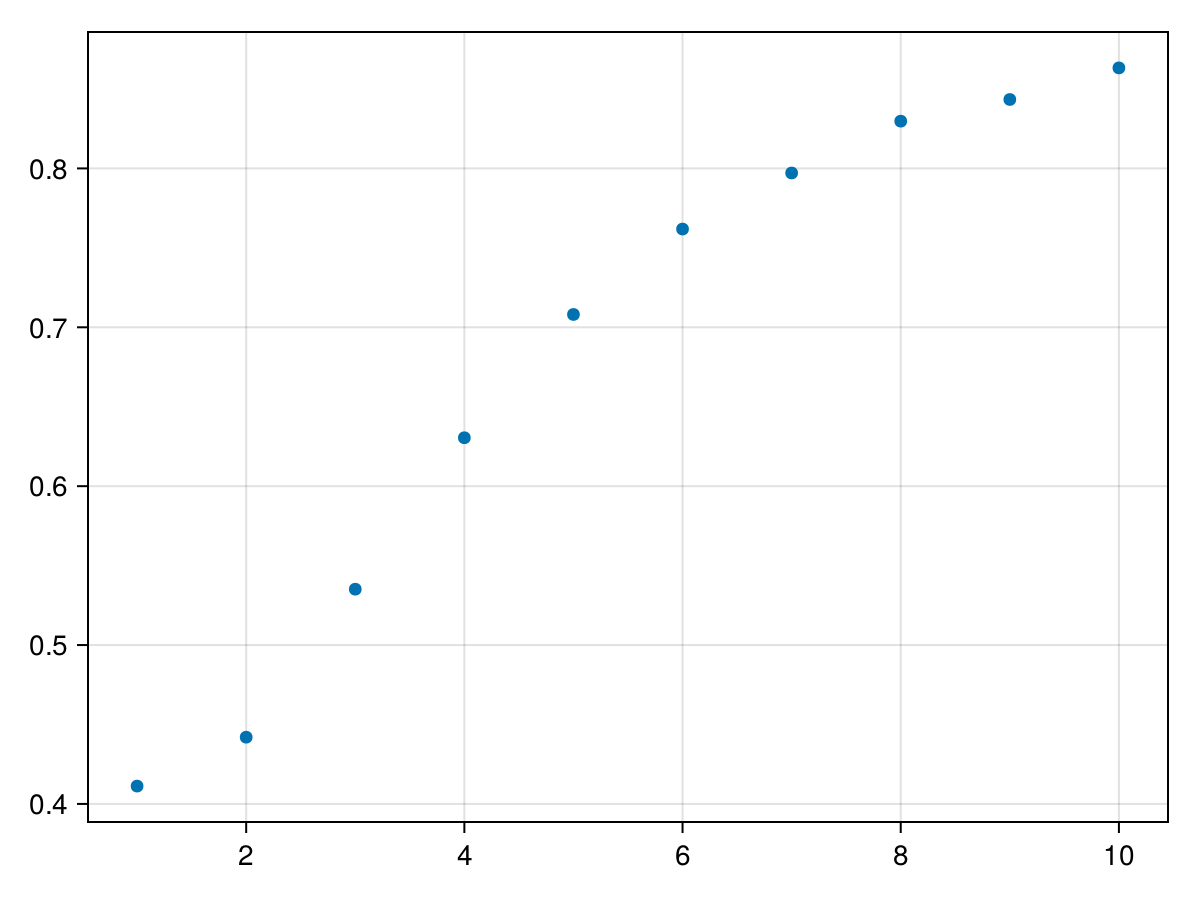

In [398]:
mean(res["p"], dims =2)[:,1] |> plot

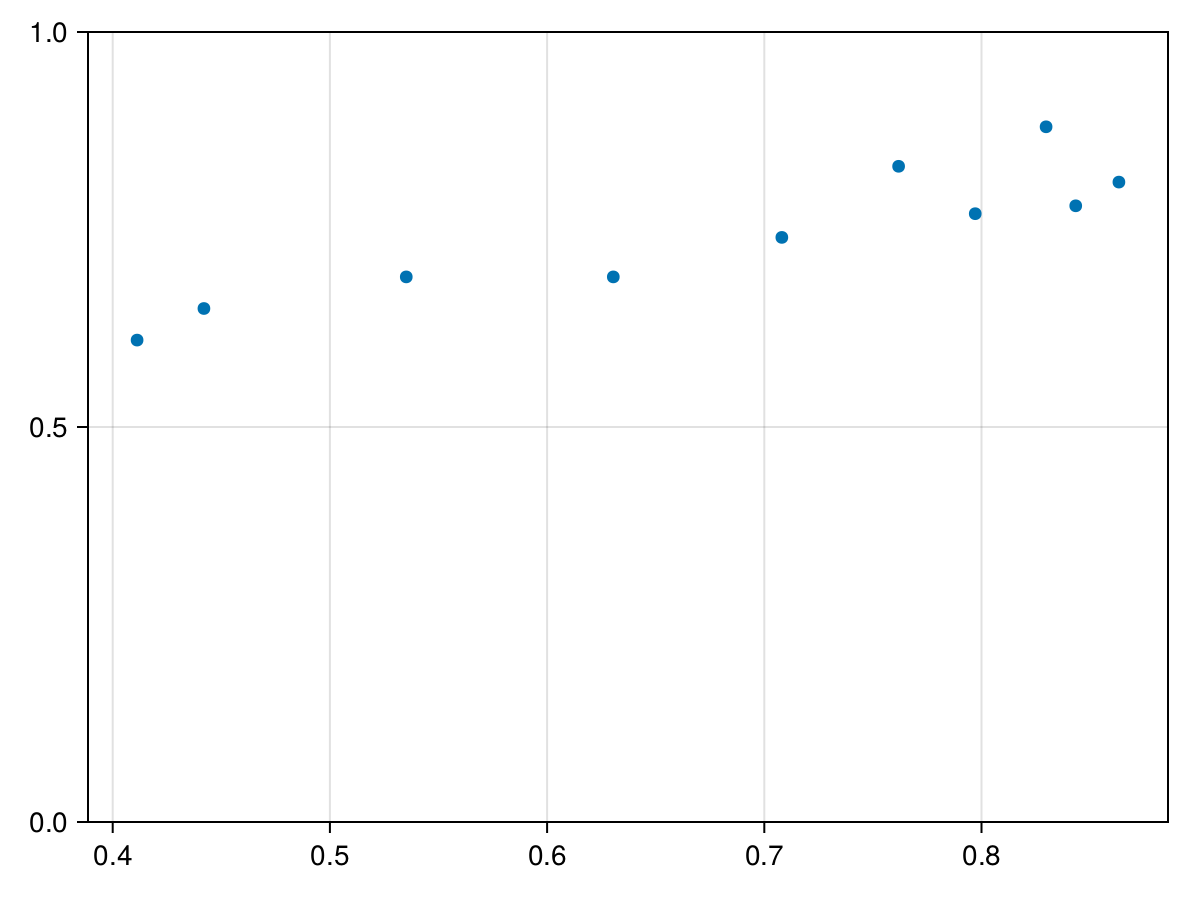

In [399]:
f,ax = plot(mean(res["p"], dims =2)[:,1][:], mean(stab,dims=2)[:,1][:])
ylims!(ax, 0,1)
f

In [378]:
cor(mean(res["p"], dims =2)[:,1][:], mean(stab,dims=2)[:,1][:])

0.5176246846465902

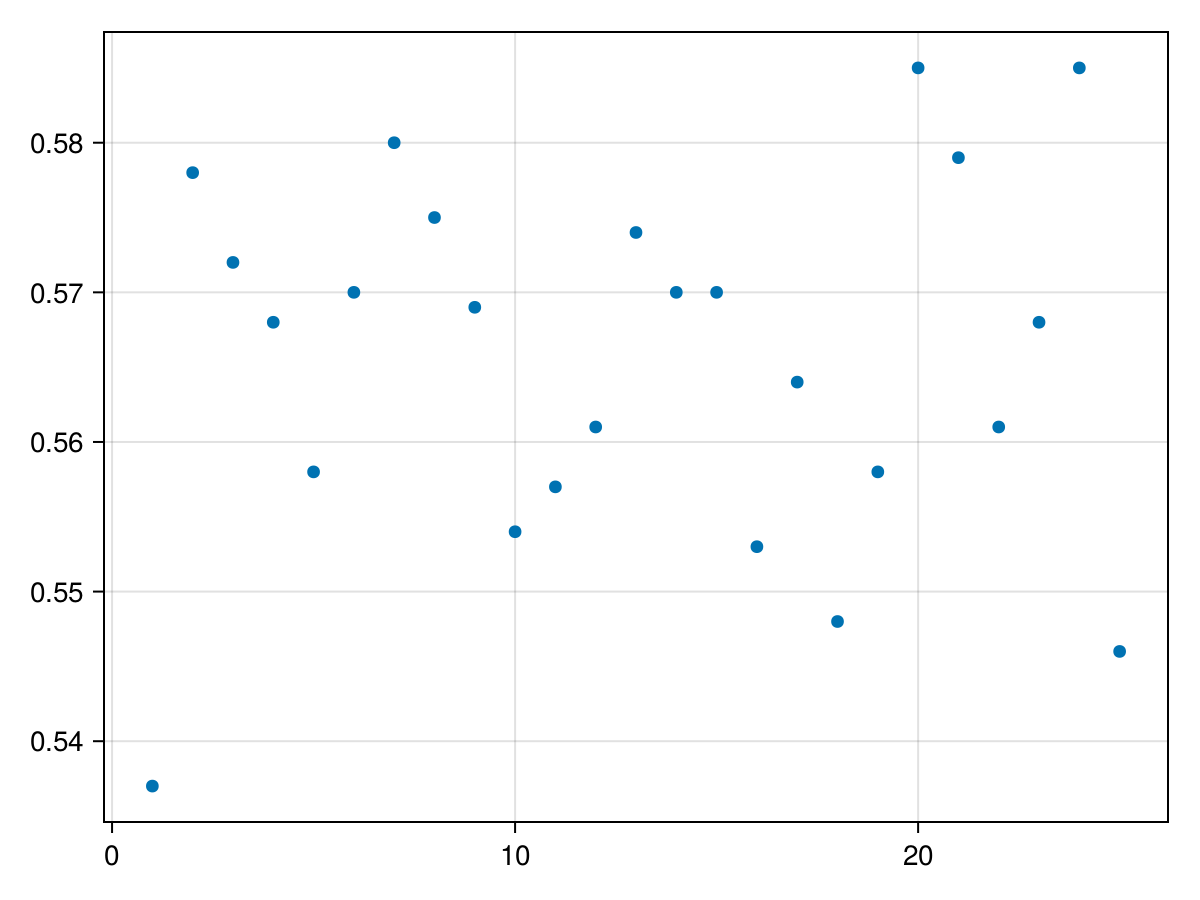

In [356]:
res = load("../Results/data/new_sims/modular_stabiltiy.jld2")

stab = [x.re < 0 for x = res["l"]]

plot(mean(stab,dims=2)[:,1])

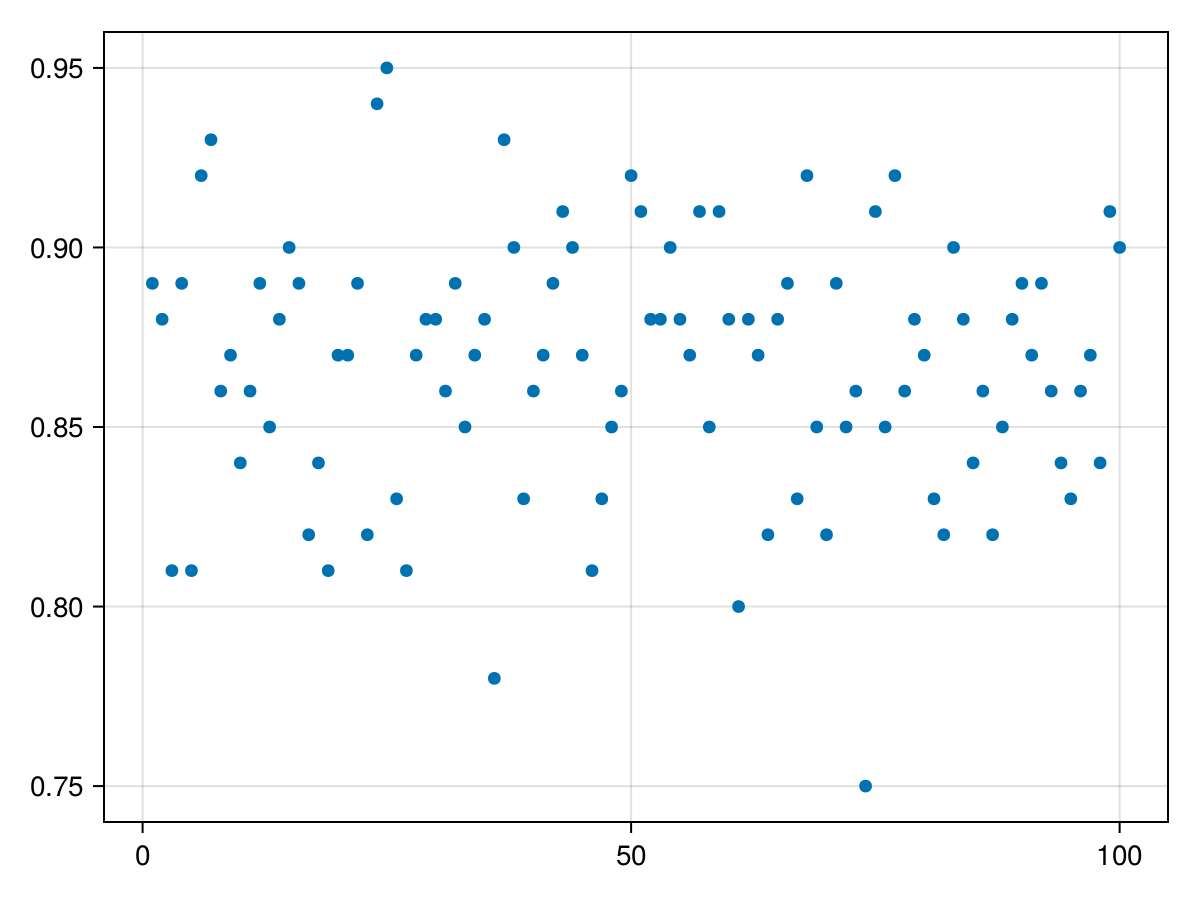

In [357]:
res = load("../Results/data/new_sims/coherence_stabiltiy.jld2")

stab = [x.re < 0 for x = res["l"]]

plot(mean(stab,dims=2)[:,1])

In [174]:
norm.(eigen(J).vectors) |> heatmap

LoadError: UndefVarError: `J` not defined

In [369]:
p.s.χ

1×10 Matrix{Float64}:
 0.2  0.2  0.2  0.2  0.0  0.0  0.0  0.0  0.0  0.2

In [212]:
J .= 0
    #loop over consumers
    for i = 1:p.N
        for j = 1:p.N
            #dxi/dxi
            if i == j
                J[i,i] = p.s.α[i] * (1 - p.s.Λ[i]) * (p.e.gx[i] - p.e.mx[i])
            end
        end
        
        for a = 1:p.M
            #dxi/dya
            J[i, a + p.N] = p.s.α[i] * ( 
                (1 - p.s.Λ[i]) * (
                (p.e.gs[i] * p.s.χ[i,a] * p.e.fy[i,a])
                ) +
                (p.s.Λ[i] * p.e.λy[i,a])
            )
        end

    end

In [219]:
p.s.χ .* p.e.fy



100×200 Matrix{Float64}:
 0.0        0.030303   0.0        …  0.0        0.0  0.0  0.030303
 0.0        0.0        0.0           0.0        0.0  0.0  0.0
 0.0344828  0.0        0.0           0.0        0.0  0.0  0.0
 0.0        0.0357143  0.0357143     0.0        0.0  0.0  0.0357143
 0.0        0.0        0.0344828     0.0        0.0  0.0  0.0
 0.0        0.0285714  0.0        …  0.0        0.0  0.0  0.0285714
 0.0        0.0        0.0           0.0        0.0  0.0  0.0
 0.0        0.0        0.0           0.0        0.0  0.0  0.030303
 0.0        0.0357143  0.0           0.0        0.0  0.0  0.0
 0.0555556  0.0555556  0.0           0.0        0.0  0.0  0.0
 0.0        0.0        0.0        …  0.0357143  0.0  0.0  0.0357143
 0.0        0.0333333  0.0           0.0333333  0.0  0.0  0.0
 0.0357143  0.0357143  0.0           0.0357143  0.0  0.0  0.0
 ⋮                                ⋱                       
 0.037037   0.037037   0.0           0.0        0.0  0.0  0.0
 0.0        0.04    

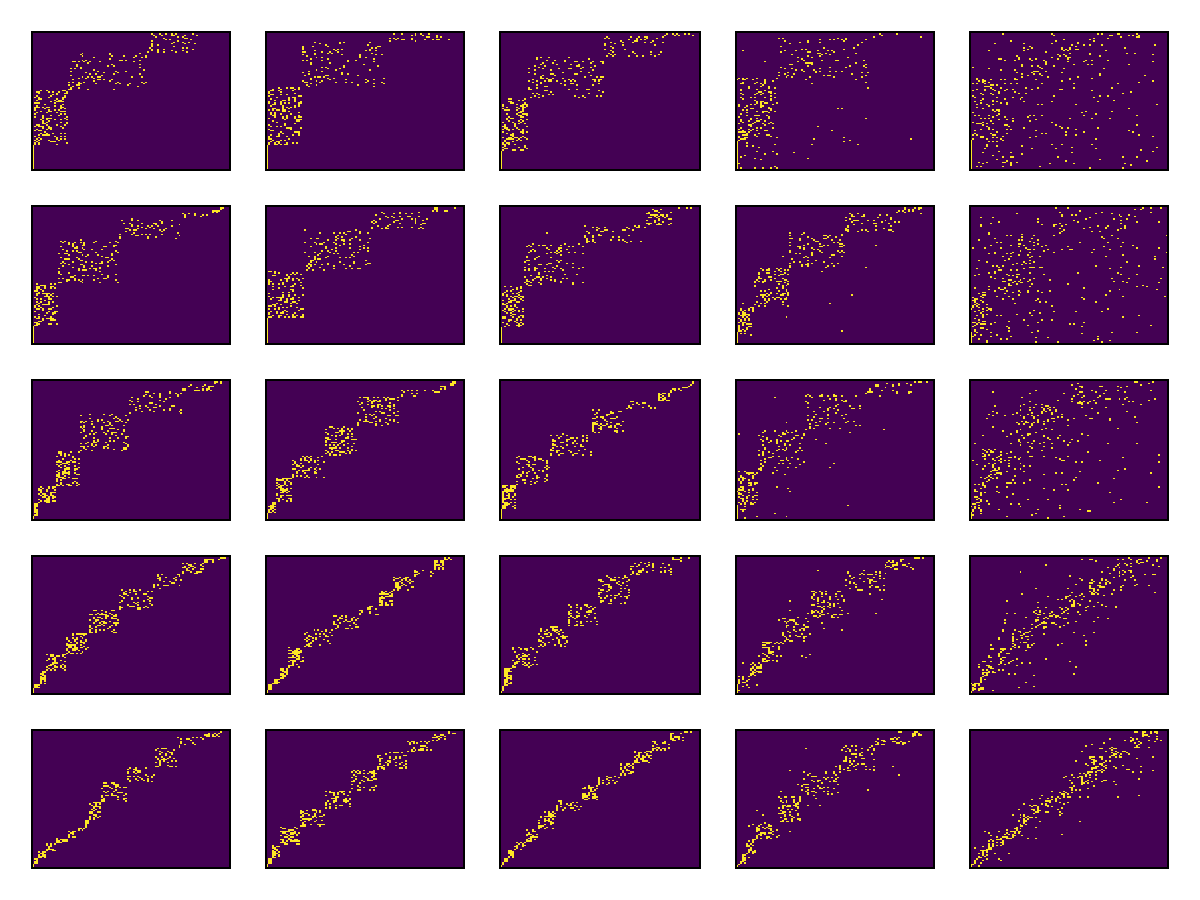

In [290]:
M = 100
λd = 3.0

h_vec = range(-2,2, length = 5)
T_vec = 10 .^ range(-2,0, length=5)

f = Figure()

for i = 1:5
    for j= 1:5
        ax = Axis(f[i,j])
        hidedecorations!(ax)
        heatmap!(ax, coherence_D(M,λd,h_vec[i],T_vec[j]))
    end
end
f

In [335]:
function get_switching_parameters(N,M,σ)

    gx = rand(Uniform(0.75,1.0)) .+ rand(Uniform(-σ,σ), N)
    gs = rand(Uniform(1,2)) .+ rand(Uniform(-σ,σ), N)
    gw = -rand(Uniform(1,2)) .+ rand(Uniform(-σ,σ), N)
    mx = rand(Uniform(1.0,1.25)) .+ rand(Uniform(-σ,σ), N)
    
    fy = rand(Uniform(σ,2)) .+ rand(Uniform(-σ,σ),N,M)
    hy = rand(Uniform(σ,2)) .+ rand(Uniform(-σ,σ),N,M)

    # fy = ones(N,M)
    # hy = ones(N,M)
    
    λy = rand(Uniform(-1,1)) .+ rand(Uniform(-σ,σ),N,M)
    # ωy = rand(Uniform(-1,1)) .+ rand(Uniform(-σ,σ),N,M)
    # λy = zeros(N,M)

    iy = rand(Uniform(σ,0.5)) .+ rand(Uniform(-σ,σ), M)
    oy = rand(Uniform(1.0,2.0)) .+ rand(Uniform(-σ,σ), M)

    return MiCRM_stability.exponential_params(gx,gs,gw,mx,fy,hy,λy,iy,oy)
end

function coherence_D(M,λd,h,T)
    #create skeleton
    TL = fill(-Inf,M)
    TL[1] = 1
    
    D = zeros(M,M)
    p = 0
    for i = 2:M
        ind = 1:(i-1)
    #choose base
        pb = (TL[ind] / maximum(TL[ind])) .^ h
        b = sample(ind, Weights(pb[ind]))
        D[b,i] = 1
        TL[i] = TL[b] + 1
    end
    
    #sort by TL
    TLind = sortperm(TL)
    D = D[TLind, TLind]
    TL = TL[TLind]
    
    #add extra links
    k = rand(Poisson(λd), M)
    x = TL .- TL'
    pl = exp.(-abs.(x .- 1)/ T)
    pl[findall(D .== 1)] .= 0
    pl[diagind(pl)] .= 0
    
    for i = 2:M
        D[sample(1:M, Weights(pl[i,:]), k[i]), i] .= 1
    end
    
    return(D)
end

function random_community(N,M,f,h,T)
    U = rand(N,M) ./ (N*M)
    U[:,end] .= 0
    
    D = coherence_D(M,3.0,h,T)
    [D[i,:] .= D[i,:] ./ sum(D[i,:]) for i = 1:M]
    D[isnan.(D)] .= 0.0
    
    Λ = fill(rand(),N)
    
    s = MiCRM_stability.get_structural_params(U,D,Λ)
    e = f(N,M, 0.1)
    u = MiCRM_stability.util_params(N,M,s,e)
    
    p = MiCRM_stability.Parameters(N,M,s,e,u)

    return(p)
end

random_community (generic function with 1 method)

In [334]:
N,M = 50,100
U = rand(N,M) ./ (N*M)
U[:,end] .= 0

D = coherence_D(M,3.0,h,T)
[D[i,:] .= D[i,:] ./ sum(D[i,:]) for i = 1:M]
D[isnan.(D)] .= 0.0

Λ = fill(rand(),N)

s = MiCRM_stability.get_structural_params(U,D,Λ)

s.ψ

50×100×100 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0